In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import torch

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

### Read in Data

In [8]:
data2009 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2009.csv")
data2010 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2010.csv")
data2011 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2011.csv")
data2012 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2012.csv")
data2013 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2013.csv")
data2014 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2014.csv")
data2015 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2015.csv")
# data2016 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2016.csv")
# data2017 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2017.csv")
# data2018 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2018.csv")
# data2019 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2019.csv")

data = data2009.append(data2010)
data = data.append(data2011)
data = data.append(data2012)
data = data.append(data2013)
data = data.append(data2014)
# data = data.append(data2015)
# data = data.append(data2016)
# data = data.append(data2017)
# data = data.append(data2018)
# data = data.append(data2019)

C:\Users\Laptop\AppData\Local\Temp\ipykernel_15372\2216357835.py:1: DtypeWarning: Columns (42,167,168,175,176,179,180,183,184,189,190,191,192,204,205,206,232,233,234,239,241,242) have mixed types. Specify dtype option on import or set low_memory=False.
  data2009 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2009.csv")
C:\Users\Laptop\AppData\Local\Temp\ipykernel_15372\2216357835.py:2: DtypeWarning: Columns (42,167,168,169,170,175,176,179,180,183,184,189,190,191,192,195,196,204,205,206,219,220,221,232,233,234,239,241,242) have mixed types. Specify dtype option on import or set low_memory=False.
  data2010 = pd.read_csv("https://raw.githubusercontent.com/Dpocklington/NFL-Betting/main/reg_pbp_2010.csv")
C:\Users\Laptop\AppData\Local\Temp\ipykernel_15372\2216357835.py:3: DtypeWarning: Columns (37,38,39,42,46,47,167,168,169,170,173,174,175,176,177,178,179,180,183,184,185,186,189,190,191,192,193,194,195,196,199,200,204,205,206,225,226,227,228,232,233

 ### Create Final Score Outcome Variable

In [9]:
def preprocessing(data):
    # Create a new column called 'final_score' and initialize it with NaN values
    data['home_final_score'] = float('nan')
    data['away_final_score'] = float('nan')

    # Loop through each game in the data
    for game_id in data['game_id'].unique():
        # Get the subset of data for the current game
        game_df = data[data['game_id'] == game_id]

        # Get the final score for the game (which should be the score of the last observation)
        home_final_score = game_df.iloc[-1]['total_home_score']
        away_final_score = game_df.iloc[-1]['total_away_score']

        # Set the 'final_score' column for all rows in this game to be the final score
        data.loc[data['game_id'] == game_id, 'home_final_score'] = home_final_score
        data.loc[data['game_id'] == game_id, 'away_final_score'] = away_final_score
        
    data['home_differential'] = data['home_final_score']-data['away_final_score']
    
    data = data[['game_id','home_team', 'away_team', 'posteam_type', 'yardline_100', 'quarter_seconds_remaining', 
                     'half_seconds_remaining', 'game_seconds_remaining', 'drive', 'down', 'ydstogo', 'no_huddle', 
                     'home_timeouts_remaining', 'away_timeouts_remaining', 'score_differential_post', 
                     'total_home_rush_epa','total_away_rush_epa', 'total_home_pass_epa','total_away_pass_epa',
                     'score_differential_post', 'total_home_score', 'total_away_score', 'home_differential']]

    data = data.dropna()
    
    data['home_team'] = data['home_team'].astype(str)
    data['away_team'] = data['away_team'].astype(str)
    data['posteam_type'] = data['posteam_type'].astype(str)
    
    df = data

    categorical_vars = ['home_team', 'away_team', 'posteam_type', 'no_huddle']
    numerical_vars = ['yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining',
                  'drive', 'down', 'ydstogo', 'home_timeouts_remaining', 'away_timeouts_remaining',
                  'score_differential_post', 'total_home_rush_epa', 'total_away_rush_epa', 'total_home_pass_epa',
                  'total_away_pass_epa', 'total_home_score', 'total_away_score']

    # One-hot encode the categorical variables
    ohe = OneHotEncoder(sparse=False)
    categorical_data = ohe.fit_transform(df[categorical_vars])

    # Standardize the numerical variables
    scaler = StandardScaler()
    numerical_data = scaler.fit_transform(df[numerical_vars])

    # Combine the categorical and numerical data into a single array
    X = np.concatenate((categorical_data, numerical_data), axis=1)
    X = np.asarray(X).astype('float32')

    # Split the data into training and testing sets
    y = df['home_differential']
    return X, y

### Create subset for half time plays

In [10]:
testing = data2015
half_time = testing[(testing['game_seconds_remaining'] > 1800) & (testing['game_seconds_remaining'] < 1810)]
training = data

### Define training and testing set

In [11]:
X_test_half, y_test_half = preprocessing(half_time)
X_test_full, y_test_full = preprocessing(testing)
X_train, y_train = preprocessing(training)

C:\Users\Laptop\AppData\Local\Temp\ipykernel_15372\3344466308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['home_final_score'] = float('nan')
C:\Users\Laptop\AppData\Local\Temp\ipykernel_15372\3344466308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['away_final_score'] = float('nan')
C:\Users\Laptop\AppData\Local\Temp\ipykernel_15372\3344466308.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

### Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=20)

# Train the model using the training data
rf_regressor.fit(X_train, y_train)

# Make predictions using the test data
y_pred_full = rf_regressor.predict(X_test_full)
y_pred_half = rf_regressor.predict(X_test_half)

# Calculate the performance of the model using the Mean Squared Error (MSE) metric
mse_full = mean_squared_error(y_test_full, y_pred_full)
mse_half = mean_squared_error(y_test_half, y_pred_half)
print("Root Mean Squared Error Full:", np.sqrt(mse_full))
print("Root Mean Squared Error Half:", np.sqrt(mse_half))



Root Mean Squared Error Full: 10.892491005648196
Root Mean Squared Error Half: 5.447902799005083


### Prediction Plots for Random Forest

In [24]:
import matplotlib.pyplot as plt

x = np.linspace(0,750,750)

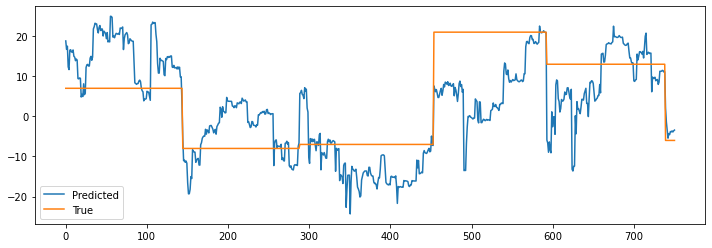

In [26]:
plt.figure(figsize=(12,4))
plt.plot(x, y_pred_full[0:750], label = "Predicted")
plt.plot(x, y_test_full[0:750], label = "True")
plt.legend()
plt.show()

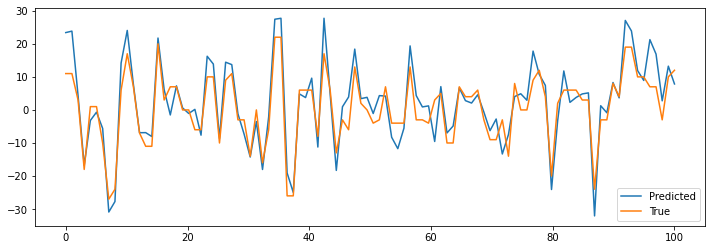

In [27]:
plt.figure(figsize=(12,4))
x = np.linspace(0,100,100)
plt.plot(x, y_pred_half[0:100], label = "Predicted")
plt.plot(x, y_test_half[0:100], label = "True")
plt.legend()
plt.show()

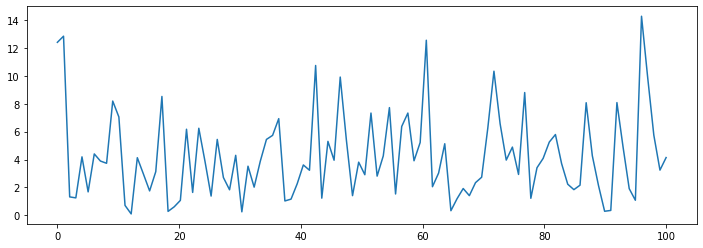

In [20]:
plt.figure(figsize=(12,4))
x = np.linspace(0,100,100)
plt.plot(x, np.abs(y_pred_half[0:100]-y_test_half[0:100]), label = "Predicted")
#plt.plot(x, y_test_half[0:100], label = "True")
plt.show()

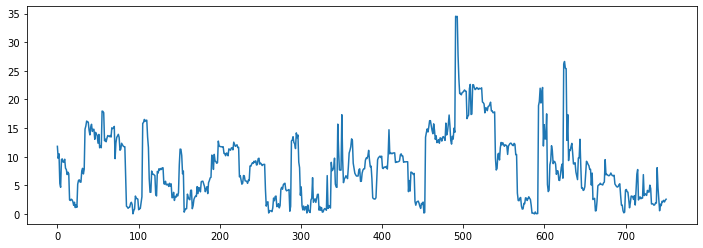

In [22]:
plt.figure(figsize=(12,4))
x = np.linspace(0,750,750)
plt.plot(x, np.abs(y_pred_full[0:750]-y_test_full[0:750]), label = "Predicted")
#plt.plot(x, y_test_half[0:100], label = "True")
plt.show()